In [511]:
import pandas as pd
import sqlite3

#### Подключение к базе данных

In [512]:
try:
    conn = sqlite3.connect('../data/checking-logs.sqlite')
    print("Успешное подключение к базе данных.")
except sqlite3.Error as e:
    print(f"Ошибка при подключении к базе данных: {e}")
    exit()

Успешное подключение к базе данных.


#### Даты, когда были и просмотры, и коммиты checker

In [513]:
query_commits = "SELECT * FROM checker WHERE uid LIKE 'user_%'"
commits = pd.read_sql_query(query_commits, conn, parse_dates=['timestamp'])
commits

,index,status,success,timestamp,numTrials,labname,uid
0,7,ready,0,2020-04-17 05:19:02.744528,1,project1,user_4
1,8,checking,0,2020-04-17 05:22:35.249331,2,project1,user_4
2,9,ready,1,2020-04-17 05:22:45.549397,2,project1,user_4
3,10,checking,1,2020-04-17 05:34:14.691200,3,project1,user_4
4,11,ready,1,2020-04-17 05:34:24.422370,3,project1,user_4
...,...,...,...,...,...,...,...
3202,3397,ready,0,2020-05-21 20:19:06.872761,7,laba06s,user_1
3203,3398,checking,0,2020-05-21 20:22:41.785725,8,laba06s,user_1
3204,3399,ready,0,2020-05-21 20:22:41.877806,8,laba06s,user_1
3205,3400,checking,0,2020-05-21 20:37:00.129678,9,laba06s,user_1


In [514]:
df = pd.DataFrame(commits)

df['date'] = df['timestamp']

df_commit = df.groupby('date').size().reset_index(name='commits')
df_commit

,date,commits
0,2020-04-17 05:19:02.744528,1
1,2020-04-17 05:22:35.249331,1
2,2020-04-17 05:22:45.549397,1
3,2020-04-17 05:34:14.691200,1
4,2020-04-17 05:34:24.422370,1
...,...,...
3202,2020-05-21 20:19:06.872761,1
3203,2020-05-21 20:22:41.785725,1
3204,2020-05-21 20:22:41.877806,1
3205,2020-05-21 20:37:00.129678,1


### Группируем df_commit по времени суток

In [515]:
df_commit['time'] = pd.cut(df_commit['date'].dt.hour,
                         bins=[-1, 4, 10, 17, 24],
                         labels=['night', 'morning', 'afternoon', 'evening'])
df_commit['date'] = df_commit['date'].dt.date
df_grouped = df_commit.groupby(['date', 'time'], observed=True)['commits'].size().unstack(fill_value=0)
df_grouped

time,night,morning,afternoon,evening
date,,,,
2020-04-17,0,13,10,0
2020-04-18,0,1,40,28
2020-04-19,2,11,9,11
2020-04-20,0,0,15,10
2020-04-21,0,0,9,16
2020-04-22,0,0,4,24
2020-04-23,2,6,15,20
2020-04-24,0,2,12,2
2020-04-25,1,21,48,34


### Построение графика

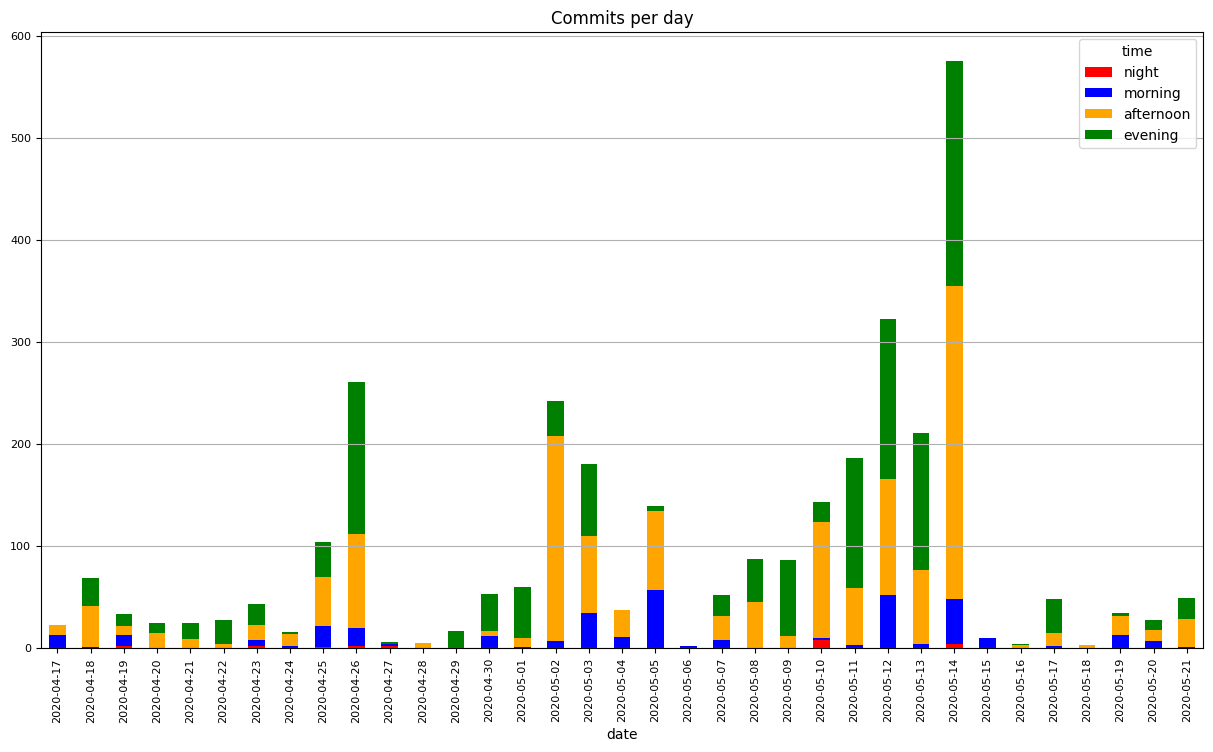

In [516]:
ax = df_grouped.plot(kind='bar', stacked=True,
              figsize=(15,8), title='Commits per day',
              color=['r', 'b', 'orange', 'g'], rot=90, fontsize=8)
ax.grid(axis='y')

### Когда наши пользователи обычно выполняют лабораторные работы: ночью, утром, днем ​​или вечером?

In [517]:
count = df_grouped.sum()
commits_by_time = df_commit.groupby('time', observed=True)['commits'].count()
sorted_commits = commits_by_time.sort_values(ascending=False)
top_2_times = sorted_commits.head(2)
print('Two most common periods:')
for time, count in top_2_times.items():
    print(f"- {time}: {count} commits")
print()

print('Answer:', df_grouped[df_grouped['evening'] > df_grouped['afternoon']].sum(axis=1).idxmax())

Two most common periods:
- afternoon: 1473 commits
- evening: 1369 commits

Answer: 2020-05-12


#### Закрытие соединения

In [518]:
conn.close()